# Pool-based sampling with CIFAR10

In [ ]:
pip install modal

In [256]:
import numpy as np
import math

from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from functools import partial
from modAL.batch import uncertainty_batch_sampling

from IPython import display
from matplotlib import pyplot as plt
%matplotlib inline

In [257]:
# imports the cifar files
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [258]:
# returns a image rgb array, label and label's name of the image with index im_idx
def cifar10_img_info(data, meta, im_idx=0):
    im = data[b'data'][im_idx, :]

    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    label = data[b'labels'][im_idx]
    category = meta[b'label_names'][data[b'labels'][im_idx]]

    return img, label, category

In [259]:
# returns a image rgb array
def img_reshape(im):
    im_r = im[0:1024].reshape(32, 32)
    im_g = im[1024:2048].reshape(32, 32)
    im_b = im[2048:].reshape(32, 32)

    img = np.dstack((im_r, im_g, im_b))
    
    return img

In [260]:
# returns X and y of the dataset, X.shape = (nº of samples x features) and y.shape = (nº of samples)
def batch_to_xy(batch):
    X = batch[b"data"]
    y = batch[b"labels"]
    y = np.array(y)
    y.reshape(y.shape[0])
    return X, y

## The dataset

In [342]:
# batch with 10000 examples
batch1 = unpickle("data_batch_1")
# meta has the labels' names
meta = unpickle("batches.meta")

Showing a example from the batch

In [343]:
# change this to see another example
img_idx = 45

In [344]:
img_ex, label_ex, category_ex = cifar10_img_info(batch1, meta, img_idx)

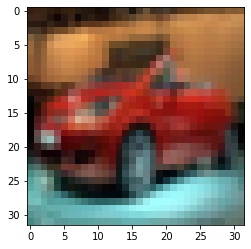

In [345]:
plt.imshow(img_ex)

In [346]:
print("Label: "+str(label_ex)+"\nCategory: "+str(category_ex))

Label: 1
Category: b'automobile'



# **Preparing the dataset**

In [375]:
X_raw, Y_raw = batch_to_xy(batch1)

In [376]:
X_raw.shape

(10000, 3072)

In [377]:
Y_raw.shape

(10000,)

In [378]:
#APPLY PCA
#https://towardsdatascience.com/integration-of-dimension-reduction-methods-and-neural-network-for-image-classification-96281963fe24
#99% -> 658
#95% -> 217
#90% -> 99
#80% -> 21
RANDOM_STATE_SEED = 123
np.random.seed(RANDOM_STATE_SEED)
pca = PCA(n_components=21, random_state=RANDOM_STATE_SEED)
tf_X = pca.fit_transform(X=X_raw)

In [380]:
tf_X.shape

(10000, 21)

In [381]:
X_raw = tf_X
X_raw.shape

(10000, 21)

In [384]:
# Isolate our examples for our labeled dataset.
n_labeled = X_raw.shape[0]   #Number of samples
training_indices = np.random.randint(low=0, high=n_labeled + 1, size=1300)
#print(training_indices)

In [385]:
X_train = X_raw[training_indices]
y_train = Y_raw[training_indices]
X_train.shape

(1300, 21)

In [386]:
# Isolate the non-training examples we'll be querying.
X_pool = np.delete(X_raw, training_indices, axis=0)
y_pool = np.delete(Y_raw, training_indices, axis=0)

In [387]:
X_pool.shape

(8784, 21)

In [388]:
y_pool.shape

(8784,)

In [389]:
# Specify our core estimator.
knn = KNeighborsClassifier(n_neighbors=3, weights='distance')

In [390]:
# Pre-set our batch sampling to retrieve 3 samples at a time.
BATCH_SIZE = 400
preset_batch = partial(uncertainty_batch_sampling, n_instances=BATCH_SIZE)

## Initializing the learner

In [391]:
learner = ActiveLearner(
    estimator=knn,
    X_training=X_train,
    y_training=y_train,
    query_strategy=preset_batch
)

From the examples: "We also set how many queries we want to make. The more the better! (Usually :) )"

In [392]:
# Isolate the data we'll need for plotting.
predictions = learner.predict(X_raw)
is_correct = (predictions == Y_raw)


In [393]:
print(is_correct)

[ True  True  True ... False  True False]


In [394]:
# Record our learner's score on the raw data.
unqueried_score = learner.score(X_raw, Y_raw)

In [395]:
print(unqueried_score)

0.347


In [396]:
N_RAW_SAMPLES = X_pool.shape[0]
N_QUERIES = N_RAW_SAMPLES // BATCH_SIZE
print(N_RAW_SAMPLES)
print(N_QUERIES)

8784
21


In [397]:
performance_history = [unqueried_score]
print(performance_history)

[0.347]


## The active learning loop

In [398]:
for index in range(N_QUERIES):
    query_index, query_instance = learner.query(X_pool)

    # Teach our ActiveLearner model the record it has requested.
    X, y = X_pool[query_index], y_pool[query_index]
    learner.teach(X=X, y=y)

    # Remove the queried instance from the unlabeled pool.
    X_pool = np.delete(X_pool, query_index, axis=0)
    y_pool = np.delete(y_pool, query_index)

    # Calculate and report our model's accuracy.
    model_accuracy = learner.score(X_raw, Y_raw)
    print('Accuracy after query {n}: {acc:0.4f}'.format(n=index + 1, acc=model_accuracy))
    # Save our model's performance for plotting.
    performance_history.append(model_accuracy)
   


Accuracy after query 1: 0.3880
Accuracy after query 2: 0.4296
Accuracy after query 3: 0.4663
Accuracy after query 4: 0.4999
Accuracy after query 5: 0.5350
Accuracy after query 6: 0.5686
Accuracy after query 7: 0.6039
Accuracy after query 8: 0.6382
Accuracy after query 9: 0.6696
Accuracy after query 10: 0.6982
Accuracy after query 11: 0.7297
Accuracy after query 12: 0.7608
Accuracy after query 13: 0.7890
Accuracy after query 14: 0.8138
Accuracy after query 15: 0.8420
Accuracy after query 16: 0.8688
Accuracy after query 17: 0.8957
Accuracy after query 18: 0.9219
Accuracy after query 19: 0.9456
Accuracy after query 20: 0.9681
Accuracy after query 21: 0.9851


We can visualize the accuracy during the training.

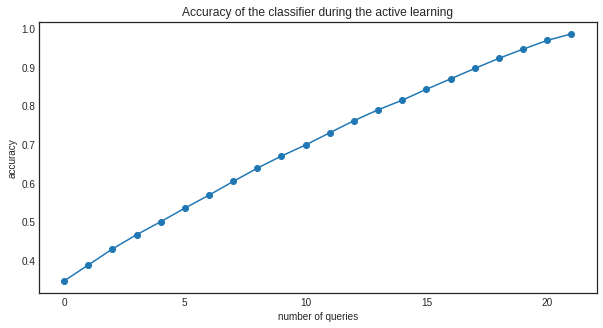

In [399]:
with plt.style.context('seaborn-white'):
    plt.figure(figsize=(10, 5))
    plt.title('Accuracy of the classifier during the active learning')
    plt.plot(range(N_QUERIES+1), performance_history)
    plt.scatter(range(N_QUERIES+1), performance_history)
    plt.xlabel('number of queries')
    plt.ylabel('accuracy')
    plt.show()

In [403]:
predictions = learner.predict(X_raw)
is_correct = (predictions == Y_raw)
np.count_nonzero(is_correct)

9851